# 1 Import Library

In [16]:
%reset -f

In [17]:
import plotting
from pyseis.wave_equations import elastic_isotropic, acoustic_isotropic
from pyseis.wavelets.elastic import Elastic2D
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, interpolate

import os
import math
pwd = os.getcwd()
%env DATAPATH={pwd}/wrk/

env: DATAPATH=/home/test01/App/01_PySeis/xu/TASK6_DAS_DATA/Data/FWI/wrk/


# 2 Read Model

In [18]:
dir_model = "./model/"
dir_seis  = "./seis/"
ox, oz = 0.0, 0.0
dx, dz = 1.0, 1.0
x1, x2 = 0.0, 550.0
z1, z2 = 0.0, 900.0


x_grid = np.arange(x1, x2 + dx, dx)
z_grid = np.arange(z1, z2 + dz, dz)
nx, nz = x_grid.size, z_grid.size
print("Grid dimensions: ", nx, nz)
model_sampling = (dx, dz)

model_padding = (100,100)
### Read (dx, dz) = (2, 2) model
vp2d_true = np.fromfile(dir_model+"vp2d_true.bin", dtype="float32")
vp2d_init = np.fromfile(dir_model+"vp2d_init.bin", dtype="float32")

vp2d_true = vp2d_true.reshape(nx,nz)
vp2d_init = vp2d_init.reshape(nx,nz)

Grid dimensions:  551 901


In [19]:
# ---- Receiver geometry ----
drec = 1.0
recz1 = 1.0
recz2 =884
recx1 = 200.0
recz = np.arange(recz1, recz2, drec)
recx = np.full(recz.shape, recx1)
recs = np.column_stack([recx, recz])

# ---- Source geometry ----
srcx = np.array([182.3])
srcz = np.full(srcx.shape, 1.0)
srcs = np.column_stack([srcx, srcz])


# Sampling in the x and z directions (5m for both in this case)
model_sampling = (dx, dz)
# Origin of the model (0, 0)
model_origins = (ox, oz)



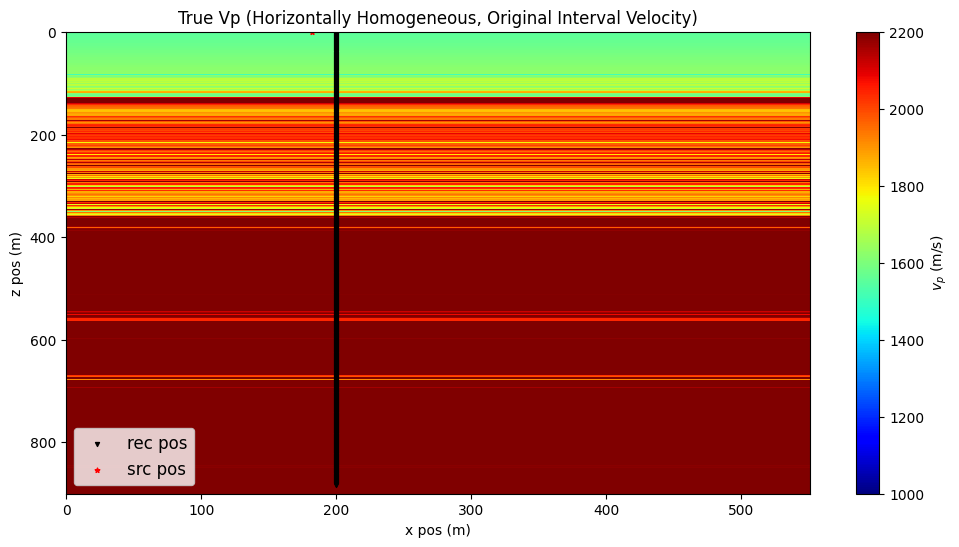

In [20]:
# ---- Plot ----
plotting.plot_model(
    vp2d_true,
    title="True Vp (Horizontally Homogeneous, Original Interval Velocity)",
    cbar=True,
    sampling=(dx, dz),
    origins=(ox, oz),
    cmap='jet',
    cbar_label='$v_p$ (m/s)',
    src_locations=srcs,
    rec_locations=recs,
    figsize=(12, 6),
    vlims=[1000, 2200]
)



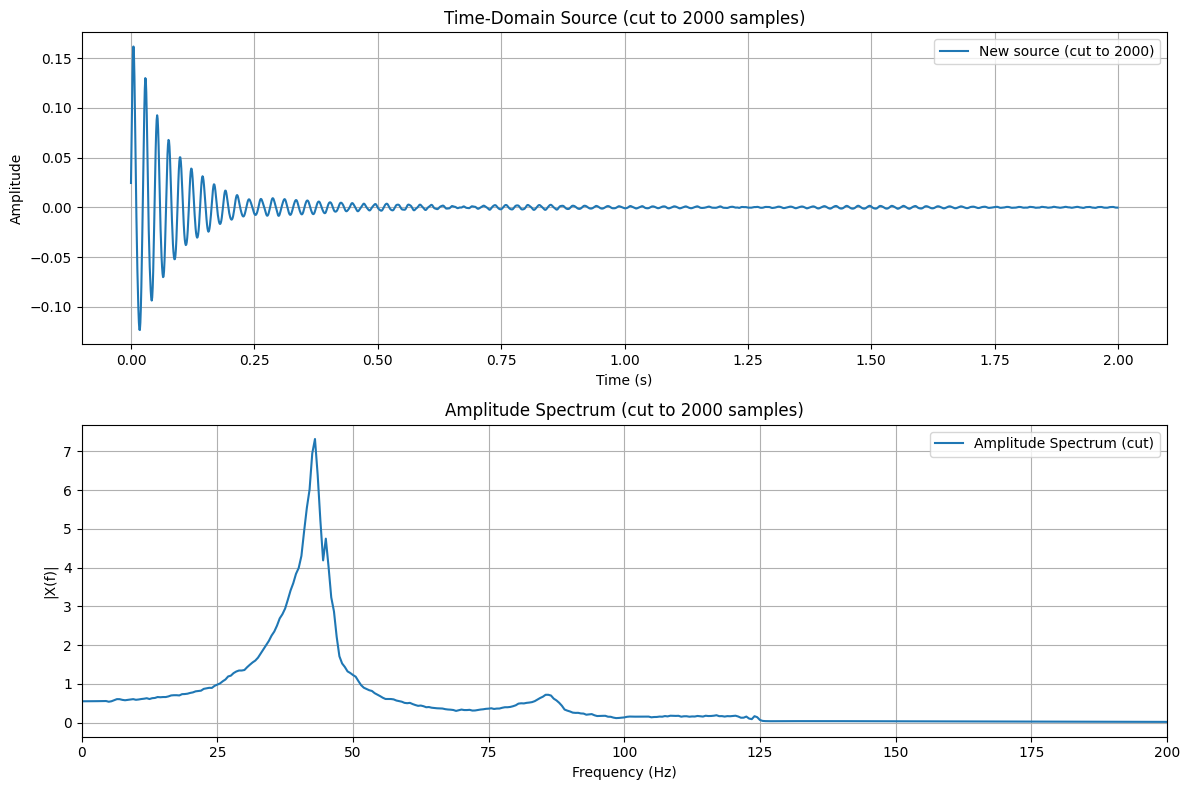

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# -------- params --------
file_path1 = "source_pilot_run3_raw.bin"
nt = 3001       # original samples
dt = 0.001
nt_new = 2000   # <--- cut down to 2000 samples

# -------- load raw --------
data1 = np.fromfile(file_path1, dtype=np.float32).astype(np.float64, copy=False)
if len(data1) < nt:
    raise ValueError(f"File has {len(data1)} samples, but nt={nt} requested.")
data1_raw = data1[:nt_new]   # <--- keep only 2000 samples

# time axis
time_axis = np.arange(nt_new) * dt

# -------- use AS-IS (cut to nt_new) --------
new_source = data1_raw.copy()

# -------- spectrum helper --------
def one_sided_spectrum(x, dt):
    X = np.fft.rfft(x)
    f = np.fft.rfftfreq(len(x), d=dt)
    return f, np.abs(X)

f_src, A_src = one_sided_spectrum(new_source, dt)

# -------- the source function form --------
# similar style, but here it's just truncated (no padding needed)
source_form = np.pad(data1_raw, (0, nt_new - len(data1_raw)), mode="constant")

# -------- plots --------
plt.figure(figsize=(12, 8))

# Time-domain (cut)
plt.subplot(2, 1, 1)
plt.plot(time_axis, new_source, label='New source (cut to 2000)')
plt.title("Time-Domain Source (cut to 2000 samples)")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
plt.grid(True); plt.legend()

# Spectrum (cut)
plt.subplot(2, 1, 2)
plt.plot(f_src, A_src, label='Amplitude Spectrum (cut)')
plt.title("Amplitude Spectrum (cut to 2000 samples)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("|X(f)|")
plt.xlim(0, 200); plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()


In [22]:
# make 2d elastic wave equation solver
acoustic_2d_obs_base = acoustic_isotropic.AcousticIsotropic2D(
    model=vp2d_true,
    model_sampling=model_sampling,
    model_padding=model_padding,
    wavelet=source_form,
    d_t=dt,
    src_locations=srcs,
    rec_locations=recs,
    model_origins=model_origins,
    subsampling=20,
    gpus=[0])

In [23]:
%%time
data_obs_base_p = acoustic_2d_obs_base.forward(vp2d_true)

CPU times: user 7.41 s, sys: 1.87 s, total: 9.28 s
Wall time: 2.2 s


In [24]:
%%time
data_cal_base_p = acoustic_2d_obs_base.forward(vp2d_init)

CPU times: user 6.73 s, sys: 1.81 s, total: 8.54 s
Wall time: 2.15 s


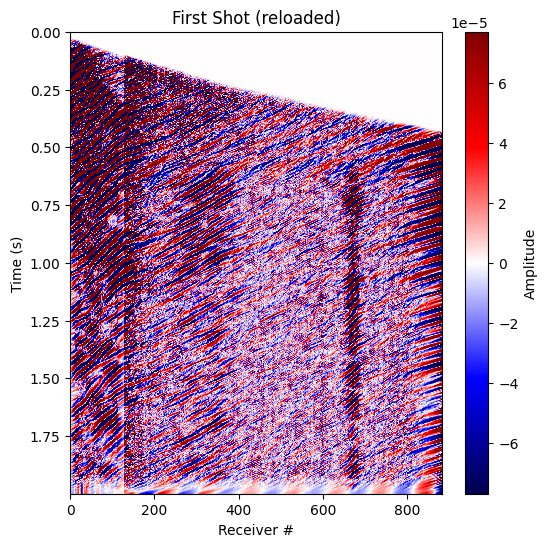

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# dimensions
nr, nt = 883, 2000
dt = 0.001  # sample interval [s]

# reload the binary file
shot0 = np.fromfile("./data/input_upgoing_FB_neartrace.bin", dtype=np.float32).reshape(nr, nt)

# build axes
time_axis = np.arange(nt) * dt
rec_axis = np.arange(nr)

# robust scaling for colormap
vmax = np.percentile(np.abs(shot0), 85)   # you can adjust 85 -> 90/95
vmin = -vmax

# plot
plt.figure(figsize=(6, 6))
plt.pcolormesh(rec_axis, time_axis, shot0.T,
               shading='nearest', cmap='seismic',
               vmin=vmin, vmax=vmax)
plt.gca().invert_yaxis()
plt.title("First Shot (reloaded)")
plt.xlabel("Receiver #")
plt.ylabel("Time (s)")
plt.colorbar(label="Amplitude")
plt.show()



In [26]:
# extend to 3D to fit with RTM process
shot0_cut_3d = shot0[np.newaxis, :, :]   # (1, 446, 2000)

In [27]:
shot0_cut_3d.shape

(1, 883, 2000)

In [28]:
data_cal_base_p.shape

(1, 883, 2000)

# Amplitude Mismatch Problem

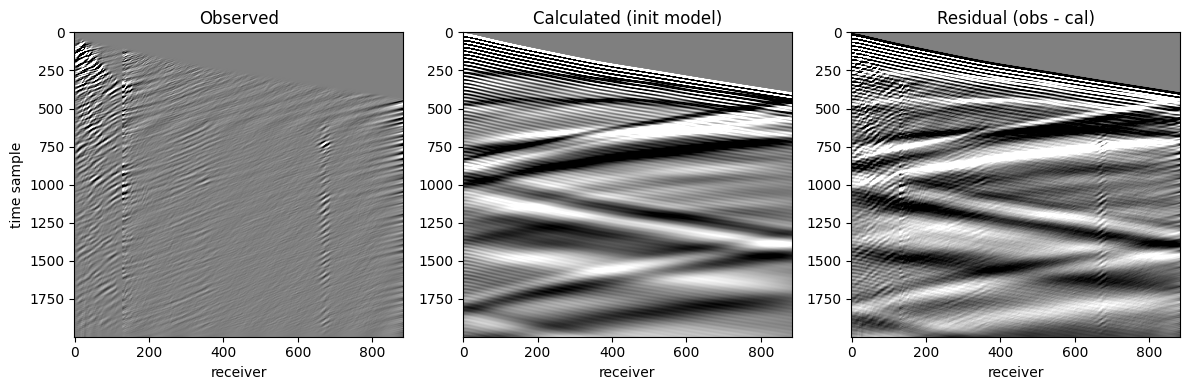

In [29]:
obs = np.squeeze(shot0_cut_3d)   # (446, 2000)
cal = np.squeeze(data_cal_base_p)   # (446, 2000)
res = obs - cal

vmax = np.percentile(np.abs(obs), 99)  # consistent scaling

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(obs.T, aspect='auto', cmap='gray', vmin=-vmax, vmax=vmax)
plt.title("Observed"); plt.xlabel("receiver"); plt.ylabel("time sample")

plt.subplot(1,3,2)
plt.imshow(cal.T, aspect='auto', cmap='gray', vmin=-vmax, vmax=vmax)
plt.title("Calculated (init model)"); plt.xlabel("receiver")

plt.subplot(1,3,3)
plt.imshow(res.T, aspect='auto', cmap='gray', vmin=-vmax, vmax=vmax)
plt.title("Residual (obs - cal)"); plt.xlabel("receiver")

plt.tight_layout(); plt.show()


In [30]:
# 1) Use your already-computed pairs:
obs = np.squeeze(shot0_cut_3d).astype(np.float32)     # (446, 2000)
cal = np.squeeze(data_cal_base_p).astype(np.float32)  # (446, 2000)

# 2) Least-squares scalar
g = (obs * cal).sum() / ((cal * cal).sum() + 1e-12)
print(f"Wavelet scale g = {g:.4g}")




Wavelet scale g = 0.0002426
